In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from helperfxns import *
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import itertools
import fbprophet
from fbprophet import Prophet as proph
from statsmodels.tools.eval_measures import rmse
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import my sales data
df = pd.read_csv('clean_data.csv')

In [4]:
df.head()

,DATE,net_sales,day_of_week,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,is_holiday
0,2017-03-14,5120.50,Tuesday,22.59,1.15,6.9,3.9,30.0,32,22,...,47.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0
1,2017-03-15,4105.00,Wednesday,19.24,0.00,0.0,5.1,24.0,27,20,...,40.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2017-03-16,6941.00,Thursday,15.21,0.00,0.0,5.1,30.0,41,23,...,33.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2017-03-17,15053.39,Friday,10.74,0.00,0.0,3.9,36.0,47,26,...,25.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2017-03-18,11338.50,Saturday,9.17,0.05,0.0,3.1,36.0,39,28,...,25.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
df.DATE = pd.to_datetime(df.DATE)

In [6]:
# organise it to the correct format for inputting to prophet
ts = df.rename(columns={'DATE': 'ds',
                        'net_sales': 'y'})

In [7]:
ts.columns

Index(['ds', 'y', 'day_of_week', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG',
       'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03',
       'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'is_holiday'],
      dtype='object')

In [8]:
ts.drop(['day_of_week', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX',
       'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04',
       'WT05', 'WT06', 'WT08', 'WT09', 'is_holiday'], axis=1, inplace=True)

In [9]:
ts.tail()

,ds,y
959,2019-10-29,3216.01
960,2019-10-30,5224.46
961,2019-10-31,7843.98
962,2019-11-01,6539.28
963,2019-11-02,11242.04


In [10]:
# instantiate the model
model = proph(interval_width=0.95)

In [11]:
model.fit(ts)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future_dates = model.make_future_dataframe(periods=14, freq='D')
future_dates.tail()

,ds
973,2019-11-12
974,2019-11-13
975,2019-11-14
976,2019-11-15
977,2019-11-16


In [13]:
forecast = model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-03-14,8302.373006,2822.192702,8922.472599,8302.373006,8302.373006,-2617.957321,-2617.957321,-2617.957321,-2456.722068,-2456.722068,-2456.722068,-161.235253,-161.235253,-161.235253,0.0,0.0,0.0,5684.415685
1,2017-03-15,8297.977642,4310.137723,10488.238182,8297.977642,8297.977642,-801.999234,-801.999234,-801.999234,-651.400101,-651.400101,-651.400101,-150.599133,-150.599133,-150.599133,0.0,0.0,0.0,7495.978407
2,2017-03-16,8293.582277,3399.257344,9719.098428,8293.582277,8293.582277,-1594.864066,-1594.864066,-1594.864066,-1456.168821,-1456.168821,-1456.168821,-138.695245,-138.695245,-138.695245,0.0,0.0,0.0,6698.718211
3,2017-03-17,8289.186913,6472.382309,12707.409722,8289.186913,8289.186913,1514.129851,1514.129851,1514.129851,1639.275107,1639.275107,1639.275107,-125.145256,-125.145256,-125.145256,0.0,0.0,0.0,9803.316764
4,2017-03-18,8284.791549,8752.729620,14927.911805,8284.791549,8284.791549,3765.425810,3765.425810,3765.425810,3875.087124,3875.087124,3875.087124,-109.661314,-109.661314,-109.661314,0.0,0.0,0.0,12050.217359


In [14]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
973,2019-11-12,3397.655497,328.664899,6471.804978
974,2019-11-13,5146.989795,2125.121093,8279.444067
975,2019-11-14,4295.636781,1184.886009,7467.697761
976,2019-11-15,7355.022920,4098.222617,10277.577226
977,2019-11-16,9566.289923,6537.736025,12766.380134


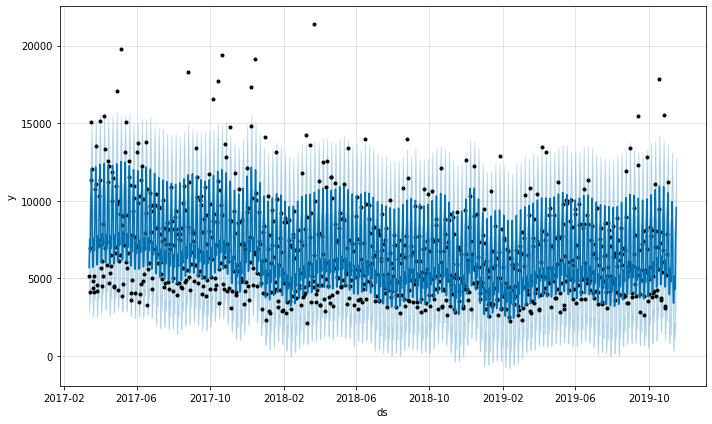

In [15]:
model.plot(forecast, uncertainty=True)
plt.show()

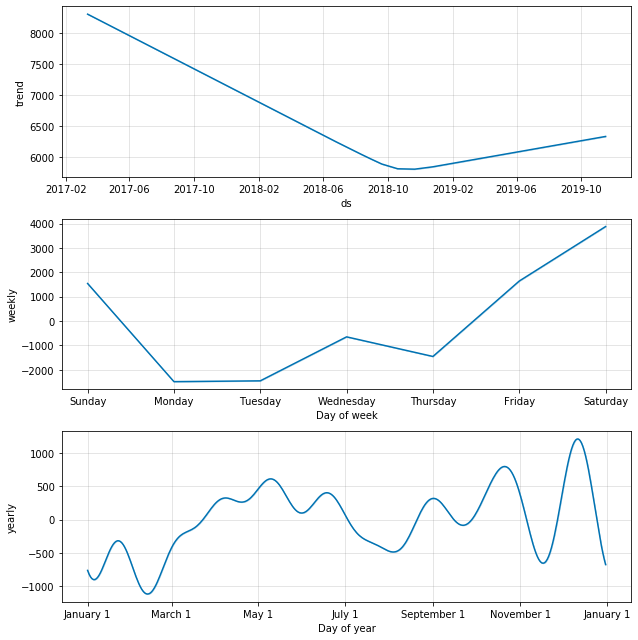

In [16]:
model.plot_components(forecast)
plt.show()

In [17]:
len(ts)

964

In [40]:
# check the validation metrics
df_cv = cross_validation(model, initial='940 days', period='90 days', horizon = '14 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-10-19 00:00:00 and 2019-10-19 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-20,8757.283542,5741.628622,11881.589791,7263.08,2019-10-19
1,2019-10-21,4728.983862,1565.397014,7859.149403,3754.00,2019-10-19
2,2019-10-22,4765.890367,1598.363872,8056.397483,3623.57,2019-10-19
3,2019-10-23,6566.426347,3230.260765,9485.101692,5415.26,2019-10-19
4,2019-10-24,5700.120224,2478.705935,8609.442862,7997.08,2019-10-19


In [41]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,coverage
0,1 days,2.232644e+06,1494.203542,1494.203542,0.205726,1.0
1,2 days,9.505935e+05,974.983862,974.983862,0.259719,1.0
2,3 days,1.304896e+06,1142.320367,1142.320367,0.315247,1.0
3,4 days,1.325184e+06,1151.166347,1151.166347,0.212578,1.0
4,5 days,5.276024e+06,2296.959776,2296.959776,0.287225,1.0
5,6 days,4.069394e+06,2017.273943,2017.273943,0.295684,1.0
6,7 days,2.090912e+07,4572.648658,4572.648658,0.293982,0.0
7,8 days,6.840545e+06,2615.443510,2615.443510,0.431369,1.0
8,9 days,2.342889e+06,1530.649855,1530.649855,0.499571,1.0
9,10 days,1.846954e+06,1359.027038,1359.027038,0.422582,1.0


In [42]:
# check the rmse over the 2 weeks
df_p['rmse'].mean()

1807.7378087188408

Seems that 28 days has a better overall rmse than 14

Let's add in holidays!

In [30]:
model2 = proph(interval_width=0.95)

In [31]:
model2.add_country_holidays(country_name='US')
model2.fit(ts)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future_dates = model2.make_future_dataframe(periods=14, freq='D')
future_dates.tail()

,ds
973,2019-11-12
974,2019-11-13
975,2019-11-14
976,2019-11-15
977,2019-11-16


In [33]:
forecast = model2.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-03-14,8270.980302,2537.905485,8622.292778,8270.980302,8270.980302,0.0,0.0,0.0,0.0,...,-2461.052575,-2461.052575,-2461.052575,-114.498972,-114.498972,-114.498972,0.0,0.0,0.0,5695.428755
1,2017-03-15,8266.504085,4689.844192,10521.073622,8266.504085,8266.504085,0.0,0.0,0.0,0.0,...,-623.078482,-623.078482,-623.078482,-100.883554,-100.883554,-100.883554,0.0,0.0,0.0,7542.542049
2,2017-03-16,8262.027868,3612.673081,9581.842730,8262.027868,8262.027868,0.0,0.0,0.0,0.0,...,-1433.648156,-1433.648156,-1433.648156,-86.051036,-86.051036,-86.051036,0.0,0.0,0.0,6742.328676
3,2017-03-17,8257.551650,6758.892401,12891.671285,8257.551650,8257.551650,0.0,0.0,0.0,0.0,...,1682.494347,1682.494347,1682.494347,-69.639632,-69.639632,-69.639632,0.0,0.0,0.0,9870.406365
4,2017-03-18,8253.075433,9073.993242,15010.526794,8253.075433,8253.075433,0.0,0.0,0.0,0.0,...,3915.338641,3915.338641,3915.338641,-51.388941,-51.388941,-51.388941,0.0,0.0,0.0,12117.025133


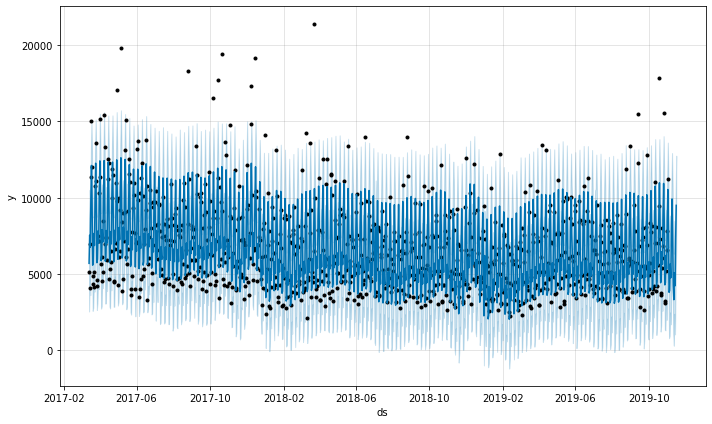

In [34]:
model2.plot(forecast, uncertainty=True)
plt.show()

In [35]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
973,2019-11-12,6279.157007,296.460546,6328.895562,6277.448136,6281.296810,0.0,0.0,0.0,0.0,...,-2461.052575,-2461.052575,-2461.052575,-509.139565,-509.139565,-509.139565,0.0,0.0,0.0,3308.964867
974,2019-11-13,6280.673781,2391.308438,8480.807372,6278.510514,6283.297073,0.0,0.0,0.0,0.0,...,-623.078482,-623.078482,-623.078482,-573.509601,-573.509601,-573.509601,0.0,0.0,0.0,5084.085697
975,2019-11-14,6282.190554,1036.187355,6992.058854,6279.622451,6285.193270,0.0,0.0,0.0,0.0,...,-1433.648156,-1433.648156,-1433.648156,-627.750517,-627.750517,-627.750517,0.0,0.0,0.0,4220.791880
976,2019-11-15,6283.707327,4521.709065,10431.244638,6280.568699,6287.159814,0.0,0.0,0.0,0.0,...,1682.494347,1682.494347,1682.494347,-670.535653,-670.535653,-670.535653,0.0,0.0,0.0,7295.666021
977,2019-11-16,6285.224100,6583.203311,12755.486049,6281.807601,6288.989564,0.0,0.0,0.0,0.0,...,3915.338641,3915.338641,3915.338641,-700.687070,-700.687070,-700.687070,0.0,0.0,0.0,9499.875671


In [36]:
len(ts)

964

In [37]:
df_cv = cross_validation(model2, initial='940 days', period='90 days', horizon = '14 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-10-19 00:00:00 and 2019-10-19 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-10-20,8816.200902,6070.783811,11955.084634,7263.08,2019-10-19
1,2019-10-21,4574.055615,1370.141308,7649.340058,3754.00,2019-10-19
2,2019-10-22,4779.645990,1792.178072,7656.641949,3623.57,2019-10-19
3,2019-10-23,6615.196616,3609.931845,9646.916938,5415.26,2019-10-19
4,2019-10-24,5742.605592,2500.111241,8570.754739,7997.08,2019-10-19


In [38]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,coverage
0,1 days,2.412185e+06,1553.120902,1553.120902,0.213838,1.0
1,2 days,6.724912e+05,820.055615,820.055615,0.218448,1.0
2,3 days,1.336512e+06,1156.075990,1156.075990,0.319043,1.0
3,4 days,1.439848e+06,1199.936616,1199.936616,0.221584,1.0
4,5 days,5.082655e+06,2254.474408,2254.474408,0.281912,1.0
5,6 days,4.333847e+06,2081.789264,2081.789264,0.305141,1.0
6,7 days,2.034794e+07,4510.868833,4510.868833,0.290010,0.0
7,8 days,7.171288e+06,2677.926117,2677.926117,0.441674,1.0
8,9 days,1.901905e+06,1379.095684,1379.095684,0.450107,1.0
9,10 days,1.891024e+06,1375.144974,1375.144974,0.427594,1.0


In [39]:
df_p['rmse'].mean()

1798.4179149089503

^ this is slightly better than without the holidays!

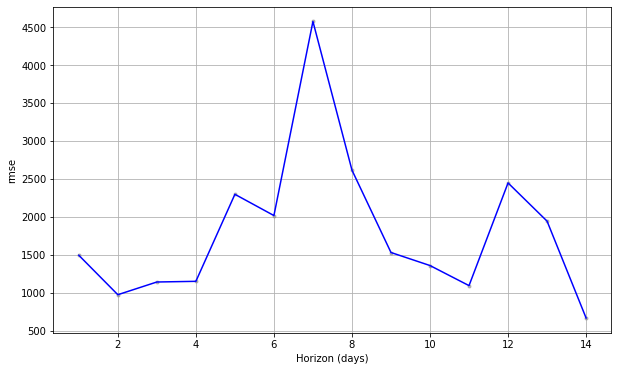

In [44]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

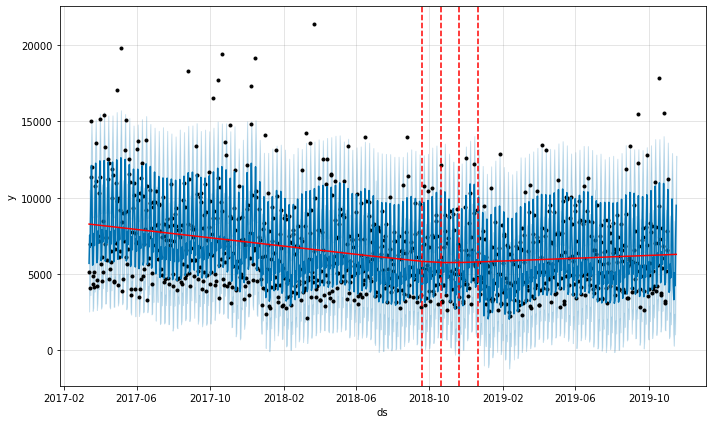

In [45]:
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)